## Step 1: Import packages and data

In [1]:
%matplotlib notebook
# %matplotlib ipympl
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import itertools as it
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from hmmlearn import hmm
from hmmlearn import base


import warnings
warnings.filterwarnings('ignore')

desired_width=320
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',20)
np.set_printoptions(linewidth=desired_width)
np.set_printoptions(threshold=sys.maxsize)

## Step 2: Feature Extraction

In [2]:
Keypoints_1_7_normalized = pd.read_json('Keypoints_1_7_normalized.json', orient='records')

In [3]:
Keypoints_1_7_normalized.head()

,Depth,Frame No.,Gesture,Joint,Sub folder No.,X,Y
0,0.352941,1,1,1,1,0.508511,0.373518
1,0.360784,1,1,2,1,0.450394,0.376146
2,0.360784,1,1,3,1,0.435149,0.531236
3,0.325490,1,1,4,1,0.433452,0.686374
4,0.372549,1,1,5,1,0.565190,0.370778


In [4]:
pivot = Keypoints_1_7_normalized.pivot_table(index = ['Gesture', 'Sub folder No.', 'Frame No.'], columns = ['Joint'], values = ['X', 'Y', 'Depth'])
display(pivot.head())

Depth                                                                    X                      ...                                       Y                                                            
Joint                                    1         2         3        4         5         6         7         1         2         3  ...         5         6         7         1         2         3         4         5         6         7
Gesture Sub folder No. Frame No.                                                                                                     ...                                                                                                    
1       1              1          0.352941  0.360784  0.360784  0.32549  0.372549  0.333333  0.317647  0.508511  0.450394  0.435149  ...  0.565190  0.582080  0.594220  0.373518  0.376146  0.531236  0.686374  0.370778  0.520458  0.683699
                       2          0.352941  0.360784  0.372549  0.32549  0.372549  0.333333  0.317647  0.508513  0.450384  0.435136  ...  0.566653  0.582094  0.594226  0.373507  0.376154  0.531316  0.686310  0.370770  0.520386  0.683577
                       3          0.352941  0.372549  0.360784  0.32549  0.372549  0.345098  0.305882  0.508519  0.450400  0.436574  ...  0.566646  0.583520  0.594237  0.376095  0.376179  0.531209  0.686341  0.370756  0.525793  0.683741
                       4          0.352941  0.360784  0.360784  0.32549  0.372549  0.325490  0.305882  0.508527  0.450392  0.436577  ...  0.566669  0.583531  0.594243  0.373441  0.376104  0.531227  0.686369  0.368059  0.520424  0.683687
                       5          0.352941  0.360784  0.360784  0.32549  0.372549  0.325490  0.305882  0.508510  0.450403  0.436578  ...  0.565187  0.583510  0.594248  0.373445  0.376112  0.531222  0.686406  0.368070  0.523081  0.683663

[5 rows x 21 columns]

In [5]:
def joint_pair_distance(row, pairs):
    x = row['X']
    y = row['Y']
    z = row['Depth']
    
    result = np.empty(0)
    for pair in pairs:
        distance = np.sqrt((x[pair[0]] - x[pair[1]])**2 + (y[pair[0]] - y[pair[1]])**2 + (z[pair[0]] - z[pair[1]])**2)
        result = np.append(result, distance)
    return result

In [6]:
pairs = list(it.combinations(np.arange(1,8), 2))
joint_pair_distance_feature = pivot.apply(lambda x: joint_pair_distance(x, pairs), axis=1).rename('Feature')
joint_pair_distance_feature.to_frame().head()

Feature
Gesture Sub folder No. Frame No.                                                   
1       1              1          [0.05870225710256071, 0.1741215965966246, 0.32...
                       2          [0.05871490807598548, 0.17513485620624372, 0.3...
                       3          [0.06133731450468716, 0.1711657100421511, 0.32...
                       4          [0.05872185604879966, 0.1735934747943889, 0.32...
                       5          [0.05869436304790603, 0.1735777769394315, 0.32...

In [7]:
joint_pair_distance_feature_normalized = joint_pair_distance_feature.apply(lambda x: x/np.max(x)).rename('Feature_normalized')
joint_pair_distance_feature_normalized.to_frame().head()

Feature_normalized
Gesture Sub folder No. Frame No.                                                   
1       1              1          [0.1700475616866118, 0.5043920693970089, 0.935...
                       2          [0.16956391705309545, 0.5057753337947788, 0.93...
                       3          [0.1771182437472947, 0.4942598187944438, 0.926...
                       4          [0.16861705826034531, 0.49846552923491233, 0.9...
                       5          [0.1687997939067418, 0.4991943255309205, 0.928...

In [8]:
joint_pair_distance_feature_normalized2 = joint_pair_distance_feature_normalized.apply(lambda x: x/joint_pair_distance_feature_normalized.iloc[0]).rename('Feature_normalized2')
joint_pair_distance_feature_normalized2.to_frame().head()

Feature_normalized2
Gesture Sub folder No. Frame No.                                                   
1       1              1          [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
                       2          [0.9971558272949089, 1.0027424388322037, 0.997...
                       3          [1.041580614214944, 0.9799119549705094, 0.9900...
                       4          [0.9915876275315089, 0.9882501321458491, 0.991...
                       5          [0.9926622424485593, 0.9896950325323272, 0.993...

## Step 3: Train Gaussian HMM models

In [9]:
gesture_number = len(Keypoints_1_7_normalized['Gesture'].unique())

In [10]:
dataset = joint_pair_distance_feature_normalized.reset_index().pivot_table(index=['Gesture', 'Sub folder No.'], values=['Feature_normalized'], aggfunc=lambda x: np.vstack(x).tolist()).iloc[:,0]
dataset.to_frame().head()

Feature_normalized
Gesture Sub folder No.                                                   
1       1               [[0.1700475616866118, 0.5043920693970089, 0.93...
        2               [[0.16412771913142, 0.5113993270366352, 0.9366...
        3               [[0.18159262784347113, 0.5552951589766314, 0.9...
        4               [[0.16063530937248446, 0.4916462813066789, 0.9...
        5               [[0.14790436627187947, 0.49390226165478524, 0....

In [11]:
msk = np.random.rand(len(dataset)) < 0.8
train_data = dataset.iloc[msk]
test_data = dataset.iloc[~msk]
print('Train dataset\'s recording number', len(train_data))
print('Test dataset\'s recording number', len(test_data))

Train dataset's recording number 60
Test dataset's recording number 18


In [12]:
hmm_train_data = [np.vstack(train_data.loc[i].values) for i in range(1, gesture_number+1)]
[print('Gesture %d Train data shape: %s' % (i+1, hmm_train_data[i].shape)) for i in range(gesture_number)]
print()
hmm_train_lengths = [train_data.loc[i].apply(len).values for i in range(1, gesture_number+1)]
[print('Gesture %d Train sequence lengths: %s' % (i+1, hmm_train_lengths[i])) for i in range(gesture_number)]
print()

Gesture 1 Train data shape: (1159, 21)
Gesture 2 Train data shape: (1223, 21)
Gesture 3 Train data shape: (1332, 21)
Gesture 4 Train data shape: (1492, 21)
Gesture 5 Train data shape: (1410, 21)

Gesture 1 Train sequence lengths: [124 128 138  95  78 100  90 140 129 137]
Gesture 2 Train sequence lengths: [ 81 211 215  66  76  90 104 101 112  93  74]
Gesture 3 Train sequence lengths: [ 84 178  76 101 102 136 109  92  86  72 164 132]
Gesture 4 Train sequence lengths: [102  85 200 155  87  87  80  87 109  83  89  83 117 128]
Gesture 5 Train sequence lengths: [ 84  86 125  83  97  98 120 124 101 105 112 137 138]



In [13]:
test_label = test_data.reset_index(0).iloc[:,0].values
test_label

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 5], dtype=int64)

In [14]:
hmm_state = range(1,31,2)

accuracy = []
best_accuracy = 0

for state in hmm_state:
    hmm_model = []
    # Train a HMM model using time sequences of training, train one HMM model for each gesture
    for i in range(gesture_number):
        hmm_model.append(hmm.GaussianHMM(n_components=state).fit(hmm_train_data[i], lengths=hmm_train_lengths[i]))

    # After training HMM models, use them to classify each time sequence of testing
    scores = np.empty((0,gesture_number))

    for sequence in test_data.values:
        score = np.empty(gesture_number)
        for k in range(gesture_number):
            score[k] = hmm_model[k].score(sequence)
        scores = np.vstack((scores, score))
        
    test_predict = np.argmax(scores, axis=1) + 1
    accuracy.append(np.sum(test_predict == test_label) / len(test_label))
    print('HMM state = %d,\tAccuracy = %.3f\nLabel:\t\t%s\nPrediction:\t%s\n' % (state, accuracy[-1], test_label, test_predict))
    
    # Save the best accuracy information for further analysis
    if accuracy[-1] > best_accuracy:
        best_accuracy = accuracy[-1]
        best_hmm_state = state
        best_test_predict = test_predict

HMM state = 1,	Accuracy = 0.778
Label:		[1 1 1 1 1 1 2 2 2 3 3 3 3 4 4 5 5 5]
Prediction:	[1 1 5 5 1 1 2 2 2 3 3 3 3 4 5 5 1 5]

HMM state = 3,	Accuracy = 0.778
Label:		[1 1 1 1 1 1 2 2 2 3 3 3 3 4 4 5 5 5]
Prediction:	[1 1 5 5 1 1 2 2 2 3 3 3 3 4 5 5 1 5]

HMM state = 5,	Accuracy = 0.833
Label:		[1 1 1 1 1 1 2 2 2 3 3 3 3 4 4 5 5 5]
Prediction:	[1 1 5 5 1 1 2 2 2 3 3 3 3 4 5 5 5 5]

HMM state = 7,	Accuracy = 0.778
Label:		[1 1 1 1 1 1 2 2 2 3 3 3 3 4 4 5 5 5]
Prediction:	[1 1 5 5 1 1 2 2 2 3 3 3 3 2 4 4 5 5]

HMM state = 9,	Accuracy = 0.778
Label:		[1 1 1 1 1 1 2 2 2 3 3 3 3 4 4 5 5 5]
Prediction:	[1 1 5 5 1 1 2 2 2 3 3 3 3 2 4 4 5 5]

HMM state = 11,	Accuracy = 0.778
Label:		[1 1 1 1 1 1 2 2 2 3 3 3 3 4 4 5 5 5]
Prediction:	[1 1 5 5 1 1 2 2 2 3 3 3 3 2 4 4 5 5]

HMM state = 13,	Accuracy = 0.889
Label:		[1 1 1 1 1 1 2 2 2 3 3 3 3 4 4 5 5 5]
Prediction:	[1 1 1 5 1 1 2 2 2 3 3 3 3 2 4 5 5 5]

HMM state = 15,	Accuracy = 0.889
Label:		[1 1 1 1 1 1 2 2 2 3 3 3 3 4 4 5 5 5]
Prediction:	[1 1

<IPython.core.display.Javascript object>


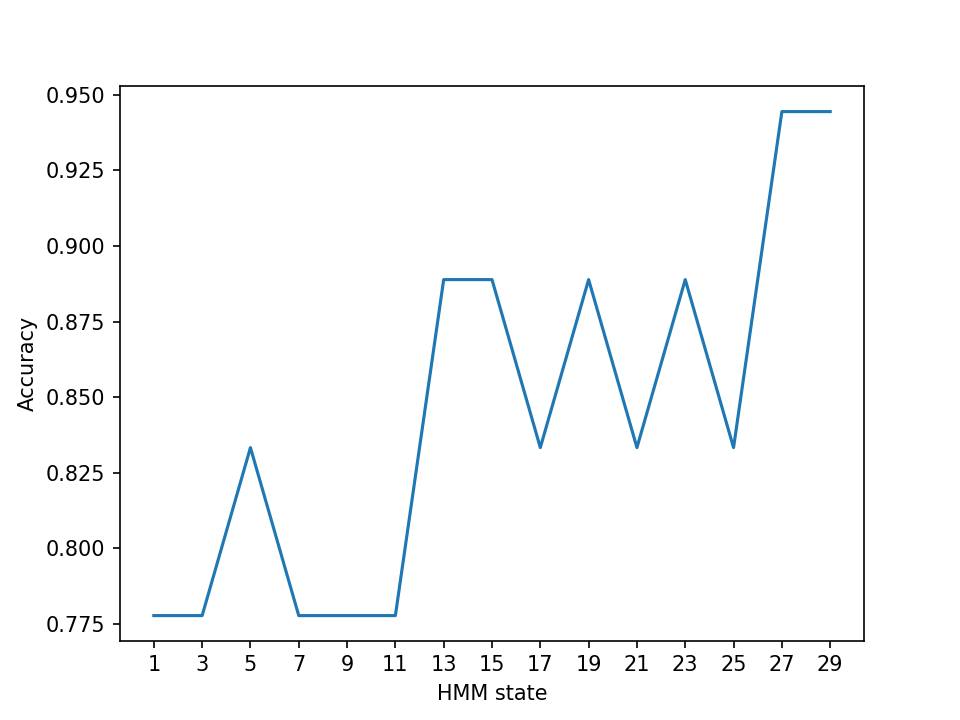

In [15]:
plt.plot(hmm_state, accuracy)
plt.xticks(hmm_state)
plt.xlabel('HMM state')
plt.ylabel('Accuracy')
plt.show()

In [18]:
print('Best accuracy occurs when:\nHMM state = %d,\t\tBest accuracy = %.3f\n' % (best_hmm_state, best_accuracy))
print('Classification Report:\n', classification_report(test_label, best_test_predict))
print('Confusion Matrix:\n', confusion_matrix(test_label, best_test_predict))

Best accuracy occurs when:
HMM state = 27,		Best accuracy = 0.944

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.83      0.91         6
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       0.75      1.00      0.86         3

    accuracy                           0.94        18
   macro avg       0.95      0.97      0.95        18
weighted avg       0.96      0.94      0.95        18

Confusion Matrix:
 [[5 0 0 0 1]
 [0 3 0 0 0]
 [0 0 4 0 0]
 [0 0 0 2 0]
 [0 0 0 0 3]]


## Step 3.b: Train discrete Multinomial HMM models (use K-Means to cluster features)

In [814]:
train_data_obs = np.array(train_data.values.tolist())
test_data_obs = np.array(test_data.values.tolist())
print(train_data_obs.shape)
print(test_data_obs.shape)

(6585, 21)
(2488, 21)


In [815]:
train_kmeans = KMeans(n_clusters=10).fit(train_data_obs)

In [817]:
train_quantized = pd.concat([train_data.reset_index(), pd.Series(train_kmeans.labels_, name='train_quantized')], axis=1)
train_quantized.head()

,Gesture,Sub folder No.,Frame No.,train_data,train_quantized
0,1,1,1,"[0.17004756153859235, 0.504392069213969, 0.935...",6
1,1,1,2,"[0.16956391697202847, 0.5057753336994646, 0.93...",6
2,1,1,3,"[0.17711824377471821, 0.49425981875567054, 0.9...",6
3,1,1,4,"[0.16861705806051375, 0.4984655292906499, 0.92...",6
4,1,1,5,"[0.1687997938923268, 0.4991943254595596, 0.928...",6


In [827]:
test_quantized = pd.concat([test_data.reset_index(), pd.Series(train_kmeans.predict(test_data_obs), name='test_quantized')], axis=1)
test_quantized.head()

,Gesture,Sub folder No.,Frame No.,test_data,test_quantized
0,1,12,1,"[0.20387359278385808, 0.48644826904588095, 0.9...",6
1,1,12,2,"[0.1602044363067046, 0.4882267721793071, 0.918...",6
2,1,12,3,"[0.20391148424238803, 0.477267477539795, 0.918...",6
3,1,12,4,"[0.1648517588622564, 0.4866220527443099, 0.939...",6
4,1,12,5,"[0.1648968868761409, 0.497191514155702, 0.9240...",6
